### Imports

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline, BSpline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

In [3]:
data = pd.read_csv("training_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812 entries, 0 to 6811
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city_name                6812 non-null   object 
 1   record_date              6812 non-null   object 
 2   AVERAGE_SPEED_DIFF       6812 non-null   object 
 3   AVERAGE_FREE_FLOW_SPEED  6812 non-null   float64
 4   AVERAGE_TIME_DIFF        6812 non-null   float64
 5   AVERAGE_FREE_FLOW_TIME   6812 non-null   float64
 6   LUMINOSITY               6812 non-null   object 
 7   AVERAGE_TEMPERATURE      6812 non-null   float64
 8   AVERAGE_ATMOSP_PRESSURE  6812 non-null   float64
 9   AVERAGE_HUMIDITY         6812 non-null   float64
 10  AVERAGE_WIND_SPEED       6812 non-null   float64
 11  AVERAGE_CLOUDINESS       4130 non-null   object 
 12  AVERAGE_PRECIPITATION    6812 non-null   float64
 13  AVERAGE_RAIN             563 non-null    object 
dtypes: float64(8), object(6)

In [4]:
#Drop unwanted columns
#AVERAGE_RAIN -> most part is null
#city name -> useless
#AVERAGE_PRECIPITATION -> it only has a value of 0
unwanted_columns = ["AVERAGE_RAIN", "city_name","AVERAGE_PRECIPITATION"]
data = data.drop(unwanted_columns, axis=1)
data.head(3)

,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS
0,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,NaN
1,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,c�u claro
2,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,NaN


In [5]:
#Rename text with unknown character, and combine nuvens quebradas +  nuvens quebrados ( both are cloud broken but spelled differently )
data['AVERAGE_CLOUDINESS'] = data['AVERAGE_CLOUDINESS'].astype('string') 
data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*claro.*$)', 'ceu claro')
data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*nublado.*$)', 'ceu pouco nublado')
data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*limpo.*$)', 'ceu limpo')
data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*quebrados.*$)', 'nuvens quebradas')

<ipython-input-5-c31112539dfb>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*claro.*$)', 'ceu claro')
<ipython-input-5-c31112539dfb>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*nublado.*$)', 'ceu pouco nublado')
<ipython-input-5-c31112539dfb>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*limpo.*$)', 'ceu limpo')
<ipython-input-5-c31112539dfb>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['AVERAGE_CLOUDINESS'] = data.AVERAGE_CLOUDINESS.str.replace(r'(^.*quebrados.*$)', 'nuvens quebradas')


In [6]:
new_data = data.copy()
new_data.head(3)
#new_data = new_data[new_data["AVERAGE_SPEED_DIFF"].str.contains("None")==False] #Drop None from AVERAGE_SPEED_DIFF
new_data['AVERAGE_SPEED_DIFF'].unique()

array(['Medium', 'High', 'None', 'Low', 'Very_High'], dtype=object)

In [7]:
#Ordinal Encoding on column LUMINOSITY
lumi_dict = {'DARK' : 1, 'LOW_LIGHT': 2, 'LIGHT': 3}
new_data['LUMINOSITY_ORDINAL'] = new_data.LUMINOSITY.map(lumi_dict)

In [8]:
new_data['AVERAGE_CLOUDINESS'].unique()

<StringArray>
[               <NA>,         'ceu claro',  'nuvens dispersas',
 'ceu pouco nublado',         'ceu limpo',    'algumas nuvens',
  'nuvens quebradas']
Length: 7, dtype: string

In [9]:
#Ordinal Encoding on column AVERAGE_CLOUDINESS
cloud_dict = {'ceu claro' : 1, 'ceu limpo': 2, 'nuvens dispersas': 3, 'nuvens quebradas': 4, 'algumas nuvens': 5, 'ceu pouco nublado': 6}
new_data['ORDINAL_CLOUDINESS'] = new_data.AVERAGE_CLOUDINESS.map(cloud_dict)

In [10]:
#Ordinal Encoding on column AVERAGE_SPEED_DIFF (Before submit on Kaggle have to do reverse encoding)
speed_dict = {'None' : 1, 'Low': 2, 'Medium': 3, 'High': 4, 'Very_High': 5}
new_data['ORDINAL_SPEED_DIFF'] = new_data.AVERAGE_SPEED_DIFF.map(speed_dict)

In [11]:
new_data['ORDINAL_CLOUDINESS'] = new_data['ORDINAL_CLOUDINESS'].fillna(method='bfill') #Fill na using next value

In [12]:
#new_data = new_data.dropna() #Drop all null rows

In [13]:
#Split Date in 4 new columns (Day, Month, Year, Hour)
new_data['record_date'] = pd.to_datetime( new_data['record_date'])
new_data['Day'] = new_data['record_date'].dt.day
new_data['month'] = new_data['record_date'].dt.month
new_data['Year'] = new_data['record_date'].dt.year
new_data['Hour'] = new_data['record_date'].dt.hour

#### First Predict Attempt 
Processes performed

Dropped AVERAGE_RAIN, city_name , AVERAGE_PRECIPITATION

Rename text with unknown character

Dropped None from AVERAGE_SPEED_DIFF

Dropped all null rows

In [14]:
new_data.head(4)

,record_date,AVERAGE_SPEED_DIFF,AVERAGE_FREE_FLOW_SPEED,AVERAGE_TIME_DIFF,AVERAGE_FREE_FLOW_TIME,LUMINOSITY,AVERAGE_TEMPERATURE,AVERAGE_ATMOSP_PRESSURE,AVERAGE_HUMIDITY,AVERAGE_WIND_SPEED,AVERAGE_CLOUDINESS,LUMINOSITY_ORDINAL,ORDINAL_CLOUDINESS,ORDINAL_SPEED_DIFF,Day,month,Year,Hour
0,2019-08-29 07:00:00,Medium,41.5,11.5,71.4,LIGHT,15.0,1019.0,100.0,3.0,<NA>,3,1.0,3,29,8,2019,7
1,2018-08-10 14:00:00,High,41.7,48.3,87.4,LIGHT,21.0,1021.0,53.0,5.0,ceu claro,3,1.0,4,10,8,2018,14
2,2019-09-01 16:00:00,High,38.6,38.4,85.2,LIGHT,26.0,1014.0,61.0,4.0,<NA>,3,1.0,4,1,9,2019,16
3,2019-02-26 11:00:00,High,37.4,61.0,94.1,LIGHT,18.0,1025.0,48.0,4.0,ceu claro,3,1.0,4,26,2,2019,11


In [15]:
#First attemp
new_data = new_data.drop(['record_date','LUMINOSITY','AVERAGE_CLOUDINESS','AVERAGE_SPEED_DIFF'],axis=1)#ORDINAL_SPEED_DIFF is AVERAGE_SPEED_DIFF (encoded)
new_data = new_data.dropna()
X = new_data.drop(['ORDINAL_SPEED_DIFF'],axis=1)        
y = new_data['ORDINAL_SPEED_DIFF'].to_frame()

In [17]:
new_data.to_csv("training_data_cleaned.csv", encoding='utf-8', index=False)

In [745]:
y.head(3)

,ORDINAL_SPEED_DIFF
0,3
1,4
2,4


#### Second Predict Attempt 
Processes performed

Dropped AVERAGE_RAIN, city_name , AVERAGE_PRECIPITATION (dropped from raw dataset)

Transformed LUMINOSITY,AVERAGE_CLOUDINESS and AVERAGE_SPEED_DIFF into numeric values (ordinal encoder).

Rename text with unknown character


filled null values with bfill

In [746]:
#from sklearn.preprocessing import LabelEncoder
##le = LabelEncoder()
#le.fit(y)
#le.classes_
#y = le.transform(y) #Label encoder performed to get MAE, MSE and RMSE scores

In [747]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=2021)
print("The Shape of X : %s, for x train : %s, for x test: %s" % (X.shape,X_train.shape, X_test.shape))
print("The Shape of y: %s, The Shape of y train : %s, The Shape of test y: %s" %(y.shape, y_train.shape, y_test.shape))

The Shape of X : (6811, 13), for x train : (5108, 13), for x test: (1703, 13)
The Shape of y: (6811, 1), The Shape of y train : (5108, 1), The Shape of test y: (1703, 1)


In [748]:
clf = DecisionTreeClassifier(random_state=2021)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2021)

#### Simple Decision Tree prediction

In [749]:
predictions = clf.predict(X_test)
predictions

array([2, 1, 3, ..., 1, 5, 3], dtype=int64)

In [750]:
#MAE
print(mean_absolute_error(y_test, predictions))
#MSE
print(mean_squared_error(y_test, predictions))
#RMSE
print(mean_squared_error(y_test, predictions, squared=False))

0.29418672930123313
0.32354668232530825
0.5688116404622081


In [751]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=20)
print(scores)
print("Result: %0.2f accuracy of standard deviation of % 0.2f" %(scores.mean(), scores.std()))

[0.72727273 0.68621701 0.67741935 0.72434018 0.71554252 0.73020528
 0.72140762 0.70967742 0.70967742 0.75953079 0.69501466 0.73823529
 0.72941176 0.71176471 0.76764706 0.70294118 0.75588235 0.72058824
 0.75588235 0.70588235]
Result: 0.72 accuracy of standard deviation of  0.02


In [752]:
from sklearn.metrics import classification_report, plot_confusion_matrix
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.87      0.84      0.86       570
           2       0.57      0.63      0.60       335
           3       0.67      0.61      0.64       400
           4       0.64      0.72      0.68       275
           5       0.84      0.76      0.79       123

    accuracy                           0.72      1703
   macro avg       0.72      0.71      0.71      1703
weighted avg       0.73      0.72      0.72      1703



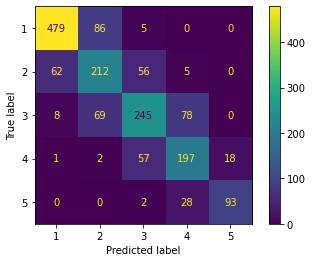

In [753]:
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

#### Grid Serach apply on DecisionTree

In [754]:
param_dict = {
    "criterion":['gini', 'entropy'],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,5)
}

In [755]:
grid = GridSearchCV(clf, param_grid=param_dict,cv=20,verbose=1,n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 20 folds for each of 648 candidates, totalling 12960 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.5334758  0.5334758  0.5334758  0.5334758  0.5334758
 0.5334758  0.5334758  0.5334758         nan 0.5334758  0.5334758
 0.5334758  0.5334758  0.5334758  0.5334758  0.5334758  0.5334758
        nan 0.5334758  0.5334758  0.5334758  0.5334758  0.5334758
 0.5334758  0.5334758  0.5334758         nan 0.5334758  0.5334758
 0.5334758  0.5334758  0.5334758  0.5334758  0.5334758  0.5334758
        nan 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604
 0.61627604 0.61627604 0.61627604        nan 0.61627604 0.61627604
 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604
        nan 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604
 0.61627604 0.61627604 0.61627604        nan 0.61627604 0.61627604
 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604 0.61627604
        nan 0.73589461 0.73589461 0.73589461 0.73589461 0.7358

GridSearchCV(cv=20, estimator=DecisionTreeClassifier(random_state=2021),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(1, 10)},
             verbose=1)

In [756]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 9}

In [757]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=4, min_samples_split=9,
                       random_state=2021)

In [758]:
grid.best_score_

0.7733095894607844

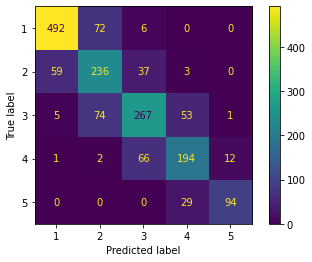

In [759]:
plot_confusion_matrix(grid, X_test, y_test)
plt.show()

#### Simple Logistic Regression Predict

In [760]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [761]:
predictions = logmodel.predict(X_test)
predictions

array([3, 1, 3, ..., 1, 3, 3], dtype=int64)

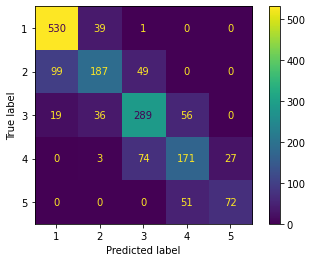

In [762]:
plot_confusion_matrix(logmodel, X_test, y_test)
plt.show()

#### Grid Serach Apply on Logistic Regression

In [763]:
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [764]:
search = GridSearchCV(logmodel, space, scoring='accuracy', n_jobs=-1, cv=cv)

In [765]:
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.77434353 0.73231419        nan        nan        nan 0.31910748
 0.60728445 0.60643644 0.57341788        nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 0.52264456
 0.72278999 0.71045406 0.65179041        nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 0.63332272
 0.76050957 0.73349104 0.69283872        nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 0.69544901
 0.76847077 0.73342632 0.6948618         nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 0.69564534
 0.77466969 0.73316591 0.69597189        nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 0.69675518
 0.77447412 0.73309888 0.69642864        nan        nan        nan
 0.77434353 0.73231419        nan        nan        nan 

Best Score: 0.7747344051775961
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


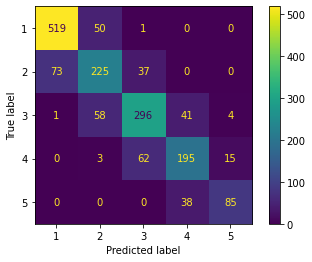

In [766]:
plot_confusion_matrix(result, X_test, y_test)
plt.show()

#### Simple SVC Predict

In [767]:
from sklearn.svm import SVC
model = SVC(random_state=2021)
model.fit(X_train, y_train)

C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SVC(random_state=2021)

In [768]:
predictions = model.predict(X_test)

In [769]:
print ("%0.2f accuracy " % (accuracy_score(y_test, predictions)))

0.35 accuracy 


#### Grid Serach Apply on SVM (SVC)

In [770]:
param_grid = {'C':[0.1,1,10,100,1000],'gamma':[1,0.1,0.01,0.001,0.0001], 'kernel':['linear','rbf']}

In [771]:
grid = GridSearchCV(SVC(random_state=2021), param_grid,refit=True, verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=0.1, gamma=1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   3.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   3.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   3.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   3.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .....................C=0.1, gamma=1, kernel=rbf; total time=   3.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=0.1, gamma=0.1, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...................C=0.1, gamma=0.1, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=0.1, gamma=0.01, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=0.1, gamma=0.01, kernel=rbf; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..............C=0.1, gamma=0.001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=0.1, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .............C=0.1, gamma=0.0001, kernel=linear; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=0.1, gamma=0.0001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ....................C=1, gamma=1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ....................C=1, gamma=1, kernel=linear; total time=   1.2s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ....................C=1, gamma=1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ....................C=1, gamma=1, kernel=linear; total time=   1.2s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ....................C=1, gamma=1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .......................C=1, gamma=1, kernel=rbf; total time=   3.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .......................C=1, gamma=1, kernel=rbf; total time=   3.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .......................C=1, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .......................C=1, gamma=1, kernel=rbf; total time=   3.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .......................C=1, gamma=1, kernel=rbf; total time=   3.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   1.2s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   1.2s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=1, gamma=0.1, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   2.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   2.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   2.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .....................C=1, gamma=0.1, kernel=rbf; total time=   2.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=1, gamma=0.01, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=1, gamma=0.01, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=1, gamma=0.01, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=1, gamma=0.01, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=1, gamma=0.01, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ....................C=1, gamma=0.01, kernel=rbf; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=1, gamma=0.001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=1, gamma=0.001, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=1, gamma=0.001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=1, gamma=0.001, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=1, gamma=0.001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...................C=1, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...................C=1, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...................C=1, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...................C=1, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...................C=1, gamma=0.001, kernel=rbf; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=1, gamma=0.0001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=1, gamma=0.0001, kernel=linear; total time=   1.3s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=1, gamma=0.0001, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=1, gamma=0.0001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=1, gamma=0.0001, kernel=linear; total time=   1.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=1, gamma=0.0001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=1, gamma=0.0001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=1, gamma=0.0001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=1, gamma=0.0001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=1, gamma=0.0001, kernel=rbf; total time=   0.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...................C=10, gamma=1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...................C=10, gamma=1, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...................C=10, gamma=1, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...................C=10, gamma=1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...................C=10, gamma=1, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ......................C=10, gamma=1, kernel=rbf; total time=   3.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ......................C=10, gamma=1, kernel=rbf; total time=   3.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ......................C=10, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ......................C=10, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ......................C=10, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=10, gamma=0.1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=10, gamma=0.1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=10, gamma=0.1, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=10, gamma=0.1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=10, gamma=0.1, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ....................C=10, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=10, gamma=0.01, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=10, gamma=0.01, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=10, gamma=0.01, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=10, gamma=0.01, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=10, gamma=0.01, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...................C=10, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...................C=10, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...................C=10, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...................C=10, gamma=0.01, kernel=rbf; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...................C=10, gamma=0.01, kernel=rbf; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=10, gamma=0.001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=10, gamma=0.001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=10, gamma=0.001, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=10, gamma=0.001, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=10, gamma=0.001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=10, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=10, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=10, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=10, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=10, gamma=0.001, kernel=rbf; total time=   0.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..............C=10, gamma=0.0001, kernel=linear; total time=   1.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=10, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=100, gamma=1, kernel=linear; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=100, gamma=1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=100, gamma=1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=100, gamma=1, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=100, gamma=1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .....................C=100, gamma=1, kernel=rbf; total time=   3.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .....................C=100, gamma=1, kernel=rbf; total time=   3.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .....................C=100, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .....................C=100, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .....................C=100, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=100, gamma=0.1, kernel=linear; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=100, gamma=0.1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=100, gamma=0.1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=100, gamma=0.1, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=100, gamma=0.1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...................C=100, gamma=0.1, kernel=rbf; total time=   2.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=100, gamma=0.01, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=100, gamma=0.01, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=100, gamma=0.01, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=100, gamma=0.01, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=100, gamma=0.01, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=100, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..............C=100, gamma=0.001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=100, gamma=0.001, kernel=rbf; total time=   0.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .............C=100, gamma=0.0001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=100, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=100, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=100, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=100, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=100, gamma=0.0001, kernel=rbf; total time=   0.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=1000, gamma=1, kernel=linear; total time=   1.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=1000, gamma=1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=1000, gamma=1, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=1000, gamma=1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=1000, gamma=1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ....................C=1000, gamma=1, kernel=rbf; total time=   3.6s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ....................C=1000, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ....................C=1000, gamma=1, kernel=rbf; total time=   3.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ....................C=1000, gamma=1, kernel=rbf; total time=   3.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ....................C=1000, gamma=1, kernel=rbf; total time=   3.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=1000, gamma=0.1, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   2.5s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..................C=1000, gamma=0.1, kernel=rbf; total time=   2.4s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ..............C=1000, gamma=0.01, kernel=linear; total time=   1.7s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ..............C=1000, gamma=0.01, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ..............C=1000, gamma=0.01, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ..............C=1000, gamma=0.01, kernel=linear; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ..............C=1000, gamma=0.01, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .................C=1000, gamma=0.01, kernel=rbf; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END .............C=1000, gamma=0.001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END .............C=1000, gamma=0.001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END .............C=1000, gamma=0.001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END .............C=1000, gamma=0.001, kernel=linear; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END .............C=1000, gamma=0.001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ................C=1000, gamma=0.001, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ................C=1000, gamma=0.001, kernel=rbf; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ................C=1000, gamma=0.001, kernel=rbf; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ................C=1000, gamma=0.001, kernel=rbf; total time=   2.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ................C=1000, gamma=0.001, kernel=rbf; total time=   2.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ............C=1000, gamma=0.0001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ............C=1000, gamma=0.0001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ............C=1000, gamma=0.0001, kernel=linear; total time=   1.8s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ............C=1000, gamma=0.0001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ............C=1000, gamma=0.0001, kernel=linear; total time=   1.9s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 1/5] END ...............C=1000, gamma=0.0001, kernel=rbf; total time=   1.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 2/5] END ...............C=1000, gamma=0.0001, kernel=rbf; total time=   1.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 3/5] END ...............C=1000, gamma=0.0001, kernel=rbf; total time=   1.0s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 4/5] END ...............C=1000, gamma=0.0001, kernel=rbf; total time=   1.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[CV 5/5] END ...............C=1000, gamma=0.0001, kernel=rbf; total time=   1.1s


C:\Users\PC\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GridSearchCV(estimator=SVC(random_state=2021),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

In [772]:
grid.best_params_

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

In [773]:
grid.best_estimator_

SVC(C=100, gamma=0.0001, random_state=2021)

In [774]:
grid.best_score_

0.7858281374884759

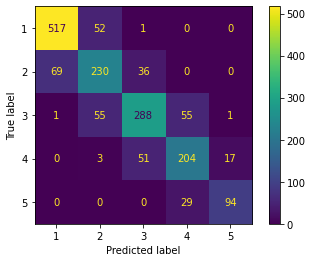

In [775]:
plot_confusion_matrix(grid, X_test, y_test)